In [1]:
#Import Packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rioxarray as rx

In [2]:
# geodataframe
balt_bg = gpd.read_file("model_inputs/bg_baltimore.csv", 
                        GEOM_POSSIBLE_NAMES="geometry",
                        KEEP_GEOM_COLUMNS="NO")

balt_bg = balt_bg.set_crs('epsg:3857')


<Axes: >

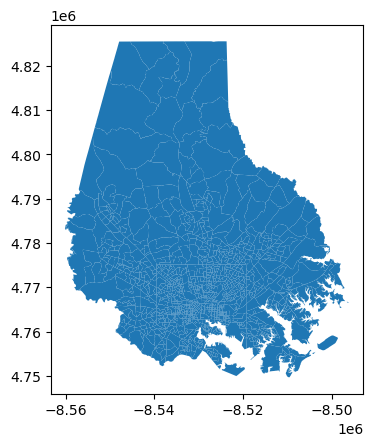

In [3]:
#visualize geodataframe
balt_bg.plot()

In [4]:
#open tif file
raster = rx.open_rasterio("flood_inputs/Block-11/Surge-11_10.tif")

In [5]:
raster = raster.rio.clip_box(-77, 39.15, -76.3, 39.9)
raster.rio.crs

CRS.from_epsg(4269)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

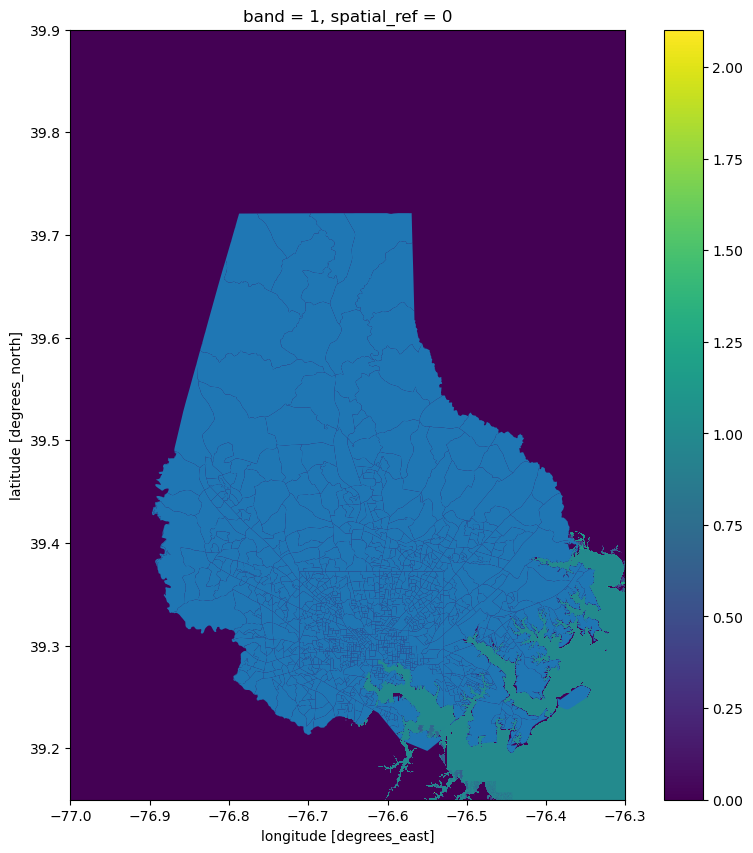

In [6]:
bg_visual = balt_bg.to_crs('epsg:4269')

f, ax = plt.subplots(1, figsize=(10, 10))
raster.plot(ax=ax)
bg_visual.plot(ax=ax)

In [7]:
#get first band of raster
band = raster[0]
x, y, extent = band.x.values, band.y.values, band.values
x, y = np.meshgrid(x, y)
x, y, extent = x.flatten(), y.flatten(), extent.flatten()

In [8]:
centroids = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(x, y, crs=band.rio.crs))
centroids['extent'] = extent

In [9]:
bg_flood_area = gpd.sjoin(bg_visual,centroids)



In [ ]:
bg_flood_max = bg_flood_area.groupby(['GISJOIN', bg_flood_area['geometry'].to_wkt()]).max()

bg_flood_max

: 